In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import Dense,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


In [45]:
# load dataset
dataframe = pd.read_csv("train.csv")
dataset = dataframe.values


In [46]:
dataframe = dataframe.drop(['RescuerID'],axis=1)
dataframe = dataframe.drop(['Name'],axis=1) 
dataframe = dataframe.drop(['PetID'],axis=1)
dataframe = dataframe.drop(['Description'],axis=1)
dataframe = dataframe.drop(['Health'],axis=1)
dataframe = dataframe.drop(['Fee'],axis=1) 
dataframe = dataframe.drop(['VideoAmt'],axis=1)
dataframe = dataframe.drop(['Color1'],axis=1) 
dataframe = dataframe.drop(['Color2'],axis=1)
dataframe = dataframe.drop(['PhotoAmt'],axis=1)
dataframe = dataframe.drop(['State'],axis=1)
X = dataframe.drop(['AdoptionSpeed'],axis=1)
Y = dataframe.AdoptionSpeed
Y

0        2
1        0
2        3
3        2
4        2
        ..
14988    2
14989    4
14990    3
14991    4
14992    3
Name: AdoptionSpeed, Length: 14993, dtype: int64

In [47]:
dataframe[dataframe['AdoptionSpeed'] == 4]

,Type,Age,Breed1,Breed2,Gender,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Quantity,AdoptionSpeed
9,2,12,265,0,2,0,2,2,3,3,3,1,4
15,1,78,218,205,1,0,2,2,3,3,3,1,4
17,1,8,307,307,2,0,2,1,2,1,1,1,4
19,2,1,266,0,3,7,1,1,2,2,2,5,4
21,1,3,307,0,2,0,2,1,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14980,1,24,307,307,2,0,3,1,1,1,3,1,4
14984,1,60,307,0,2,0,2,2,3,3,3,1,4
14985,1,24,179,307,1,7,2,2,3,3,2,1,4
14989,2,60,265,264,3,7,2,2,1,1,1,2,4


In [14]:
X

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Quantity
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,2,266,0,3,1,0,0,2,2,2,2,2,4
14989,2,60,265,264,3,1,4,7,2,2,1,1,1,2
14990,2,2,265,266,3,5,6,7,3,2,2,1,3,5
14991,2,9,266,0,2,4,7,0,1,1,1,1,1,1


Class=2, n=4197 (20.000%)
Class=0, n=4197 (20.000%)
Class=3, n=4197 (20.000%)
Class=1, n=4197 (20.000%)
Class=4, n=4197 (20.000%)


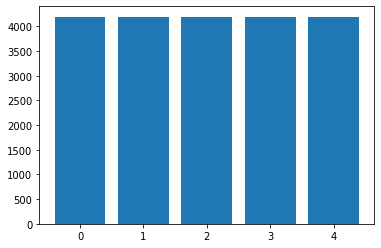

In [48]:
# example of oversampling a multi-class classification dataset with a custom strategy
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

strategy = {0:4197, 1:4197, 2:4197, 3:4197, 4:4197}
oversample = SMOTE(sampling_strategy=strategy)
X, Y = oversample.fit_resample(X, Y)
# summarize distribution
counter = Counter(Y)
for k,v in counter.items():
	per = v / len(Y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [49]:
classifier= LogisticRegression()  
classifier.get_params()
classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
df1=pd.DataFrame(classifier.coef_)

In [53]:
df1=df1.transpose()

In [54]:
dataframe.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color3', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Quantity',
       'AdoptionSpeed'],
      dtype='object')

In [55]:
df2 = pd.DataFrame(dataframe.columns)

In [56]:
df1["Features"]= df2

In [57]:
df1

,0,1,2,3,4,Features
0,0.187952,0.102119,-0.050548,-0.192215,-0.047307,Type
1,-0.114352,-0.168480,-0.030829,-0.002813,0.316475,Age
2,-0.138937,-0.180961,0.002352,-0.017748,0.335294,Breed1
3,0.178366,-0.080766,-0.063718,0.000102,-0.033984,Breed2
4,-0.327176,-0.021556,0.037965,0.141241,0.169525,Gender
5,-0.078914,0.038755,0.037370,0.002455,0.000335,Color3
6,-0.068795,-0.001358,0.020197,0.063593,-0.013637,MaturitySize
7,0.102527,-0.002823,-0.014805,-0.029772,-0.055127,FurLength
8,-0.440487,0.011668,0.138889,0.123856,0.166075,Vaccinated
9,0.013977,0.113006,0.019176,-0.073136,-0.073025,Dewormed


In [58]:
X_train_norm = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(
                            X_train_norm, Y, test_size=0.3, random_state=42,stratify=Y)

In [59]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

In [60]:
y_pred= clf_dt.predict(X_test)  
print(classification_report(Y_test, y_pred))
print("Accuracy for model 3: %.2f" % (accuracy_score(Y_test, y_pred) * 100))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1259
           1       0.38      0.43      0.40      1259
           2       0.30      0.30      0.30      1259
           3       0.36      0.32      0.34      1260
           4       0.39      0.32      0.35      1259

    accuracy                           0.43      6296
   macro avg       0.42      0.43      0.42      6296
weighted avg       0.42      0.43      0.42      6296

Accuracy for model 3: 42.85


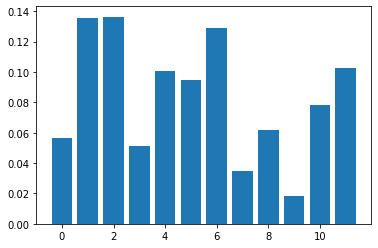

In [ ]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()